In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import MDAnalysis as md
import math
import string, sys, os

In [20]:
PSF = r'w4096.psf'
DCD = r'sample.dcd'
sim = md.Universe(PSF, DCD)

bins_per_axis = 4
x_bins = bins_per_axis
y_bins = bins_per_axis
z_bins = bins_per_axis  # Change to 1 for 2D
partitions = x_bins * y_bins * z_bins
box_size = sim.trajectory[0].dimensions[0]
partition_size = box_size / bins_per_axis
radius_from_center = 3

assert partition_size >= 2*radius_from_center, (f"Partition size is {partition_size} cubic angstroms, which is less than 2r ({2*radius_from_center}).\nDecrease radius_from_center or bins per acis to continue.")

print(f"Partition Size: {partition_size} cubic angstroms")
nframes = sim.trajectory.n_frames

Partition Size: 12.5 cubic angstroms


C:\Users\xny\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\MDAnalysis\coordinates\DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [21]:
def get_distinct_color(i, total):
    if total <= 20:
        cmap = plt.get_cmap('tab20', total)
        return cmap(i)
    elif total <= 40:
        if i < 20:
            cmap = plt.get_cmap('tab20', 20)
            return cmap(i)
        else:
            cmap = plt.get_cmap('tab20b', 20)
            return cmap(i-20)
    else:
        cmap = plt.get_cmap('hsv', total)
        return cmap(i)

def index_to_xyz(index):
    z = index // (x_bins * y_bins)
    remainder = index % (x_bins * y_bins)
    y = remainder // x_bins
    x = remainder % x_bins
    return [x, y, z]

def center_of_box(index):
    boxcoords = index_to_xyz(index)
    boxcentercoords = []
    for pos in boxcoords:
        boxcentercoords.append(round(((pos / bins_per_axis) * box_size + (box_size / bins_per_axis) / 2), 2))
    return boxcentercoords

def distance3D(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0]) ** 2 + (coord1[1] - coord2[1]) ** 2 + (coord1[2] - coord2[2]) ** 2)

In [22]:
# Count oxygens near center for each box in each frame
particles_near_center = []
oxygens = sim.select_atoms('name OH2')

for frame in range(nframes):
    sim.trajectory[frame]
    for atom in oxygens:
        atom.position += box_size/2
    boxes = [[] for _ in range(partitions)]
    for particle in oxygens.atoms.positions:
        xID = int((particle[0] / box_size) / (1 / (x_bins)))
        yID = int((particle[1] / box_size) / (1 / (y_bins)))
        zID = int((particle[2] / box_size) / (1 / (z_bins)))

        xID = min(max(xID, 0), x_bins - 1)
        yID = min(max(yID, 0), y_bins - 1)
        zID = min(max(zID, 0), z_bins - 1)
        boxIndex = xID + yID * x_bins + zID * x_bins * y_bins
        boxes[boxIndex].append(particle)
    frame_counts = []
    for i, box in enumerate(boxes):
        center = center_of_box(i)
        count = 0
        for particle in box:
            if distance3D((particle[0], particle[1], particle[2]), center) <= radius_from_center:
                count += 1
        frame_counts.append(count)
    particles_near_center.append(frame_counts)

In [23]:
# Flatten for histogram
flat_counts = []
for frame in particles_near_center:
    for count in frame:
        flat_counts.append(count)

[0, 1, 2, 3, 4, 5, 6, 7]


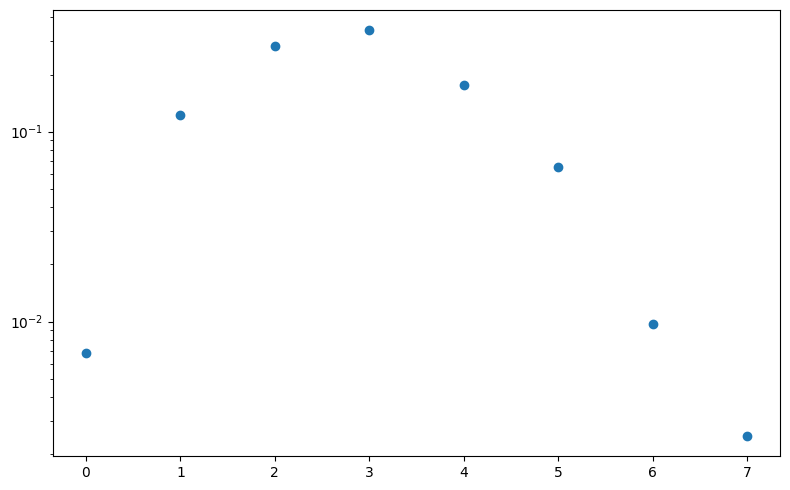

In [24]:
counts_per_n = list(range(0, max(flat_counts)))
print(counts_per_n)
for n in flat_counts:
    counts_per_n[n-1] += 1
for i in range(len(counts_per_n)):
    counts_per_n[i] /= len(flat_counts)

fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)

ax.scatter(list(range(0, max(flat_counts))), counts_per_n)
ax.set_yscale('log')
plt.show()

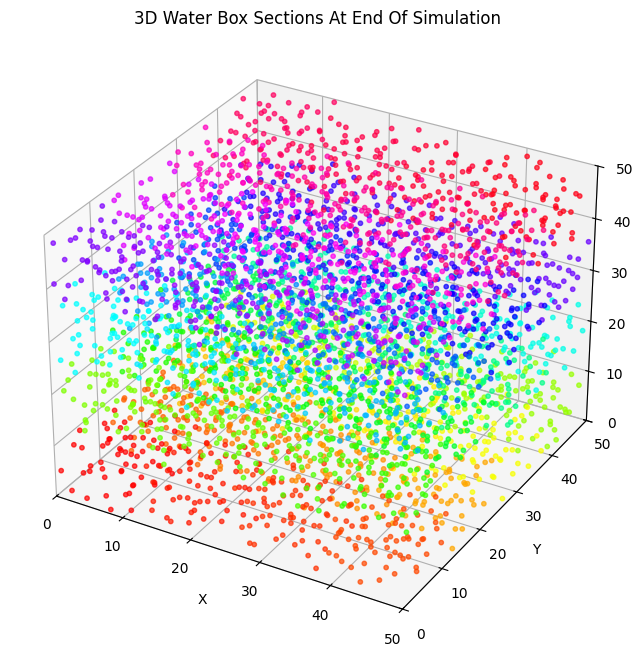

In [25]:
d = input("Dimensions? (2 or 3): ").strip()
if d == "2":
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    for i, box in enumerate(boxes):
        if len(box) == 0:
            continue
        box = np.array(box)
        if box.ndim == 2 and box.shape[1] >= 2:
            ax.scatter(box[:, 0], box[:, 1], color=get_distinct_color(i, partitions), label=f'Section {i+1}', s=10, alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('XY-Bisection')
    # ax.legend()

    fig2, ax2 = plt.subplots(figsize=(8, 8))
    ax2.set_xlim(0, box_size)
    ax2.set_ylim(0, box_size)
    for i, box in enumerate(boxes):
        if len(box) == 0:
            continue
        box = np.array(box)
        if box.ndim == 2 and box.shape[1] >= 3:
            ax2.scatter(box[:, 0], box[:, 2], color=get_distinct_color(i, partitions), label=f'Section {i+1}', s=10, alpha=0.7)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Z')
    ax2.set_title('XZ-Bisection')
    # ax2.legend()
else:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_zlim(0, box_size)
    for i, box in enumerate(boxes):
        if len(box) == 0:
            continue
        box = np.array(box)
        if box.ndim == 2 and box.shape[1] >= 3:
            ax.scatter(box[:, 0], box[:, 1], box[:, 2], color=get_distinct_color(i, partitions), label=f'Section {i+1}', s=10, alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Water Box Sections At End Of Simulation')
    # ax.legend()
plt.show()